# Drag

In [1]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [2]:
params = modsim.Params(
    mass = 0.0025,      # kg
    diameter = 0.019,   # m
    rho = 1.2,          # kg/m**3
    g = 9.8,            # m/s**2
    v_init = 0,         # m / s
    v_term = 18,        # m / s
    height = 381,       # m
    t_end = 30,         # s
)

In [3]:
def make_system(params):
    init = modsim.State(y=params.height, v=params.v_init)

    area = numpy.pi * (params.diameter/2)**2

    C_d = (2 * params.mass * params.g / 
           (params.rho * area * params.v_term**2))

    return modsim.System(
        init=init,
        area=area,
        C_d=C_d,
        mass=params.mass,
        rho=params.rho,
        g=params.g,
        t_end=params.t_end,
    )

In [4]:
system = make_system(params)
system

namespace(init=y    381
               v      0
               Name: state, dtype: int64,
          area=0.0002835287369864788,
          C_d=0.4445009981135434,
          mass=0.0025,
          rho=1.2,
          g=9.8,
          t_end=30)

In [5]:
system.C_d

0.4445009981135434

In [6]:
params2 = params.set(v_term=20)

In [7]:
system2 = make_system(params2)
system2.C_d

0.3600458084719701

### Simulating the Penny Drop

In [8]:
def slope_func(t, state, system):
    y, v = state
    rho, C_d, area = system.rho, system.C_d, system.area
    mass, g = system.mass, system.g
    
    f_drag = rho * v**2 * C_d * area / 2
    a_drag = f_drag / mass
    
    dydt = v
    dvdt = -g + a_drag
    
    return dydt, dvdt

In [9]:
slope_func(0, system.init, system)

(0, -9.8)

In [10]:
def event_func(t, state, system):
    y, v = state
    return y

In [11]:
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [12]:
results.tail()

,y,v
21.541886,16.147430,-18.001510
21.766281,12.112646,-18.006240
21.990676,8.076745,-18.009752
22.215070,4.039275,-18.011553
22.439465,0.000000,-18.011383


In [13]:
t_sidewalk = results.index[-1]
t_sidewalk

22.43946505804431

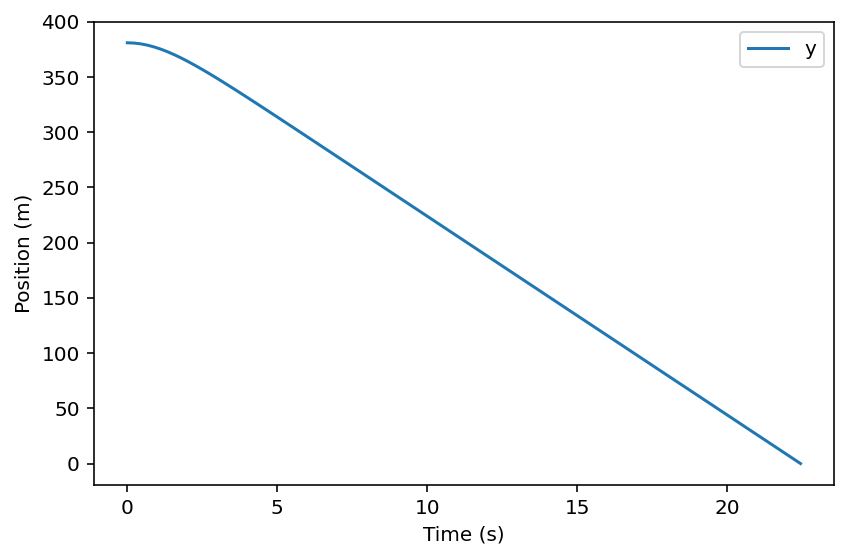

In [14]:
def plot_position(results):
    results.y.plot()
        
    modsim.decorate(xlabel='Time (s)', ylabel='Position (m)')
    
plot_position(results)

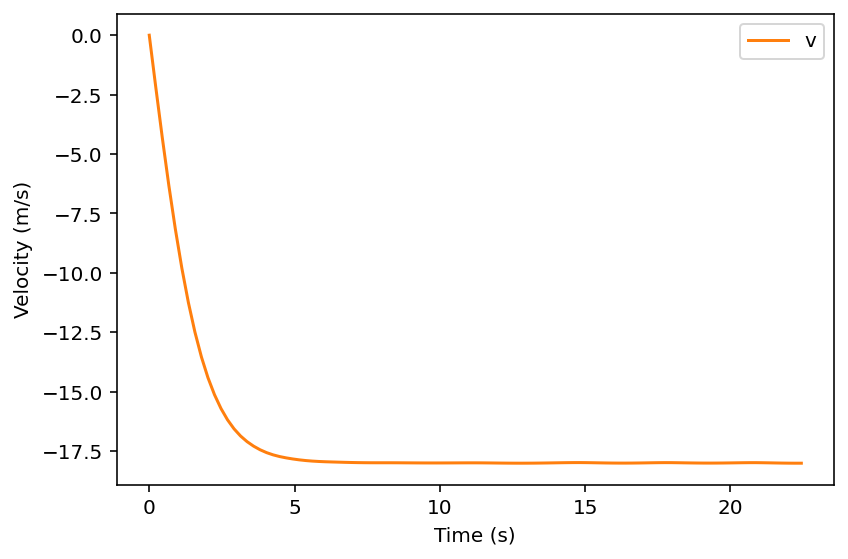

In [15]:
def plot_velocity(results):

    results.v.plot(color='C1', label='v')
        
    modsim.decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

### Exercise 1
Run the simulation with a downward initial velocity that exceeds the penny’s terminal velocity.

What do you expect to happen? Plot velocity and position as a function of time, and see if they are consistent with your prediction.

Hint: Use `params.set` to make a new `Params` object with a different initial velocity.

In [16]:
params.__dict__

{'mass': 0.0025,
 'diameter': 0.019,
 'rho': 1.2,
 'g': 9.8,
 'v_init': 0,
 'v_term': 18,
 'height': 381,
 't_end': 30}

In [27]:
params1 = params.set(v_init=-36)

In [28]:
system1 = make_system(params1)
system1

namespace(init=y    381
               v    -36
               Name: state, dtype: int64,
          area=0.0002835287369864788,
          C_d=0.4445009981135434,
          mass=0.0025,
          rho=1.2,
          g=9.8,
          t_end=30)

In [29]:
slope_func(0, system1.init, system1)

(-36, 29.400000000000002)

In [30]:
results1, details1 = modsim.run_solve_ivp(system1, slope_func, events=event_func)
details1.message

'A termination event occurred.'

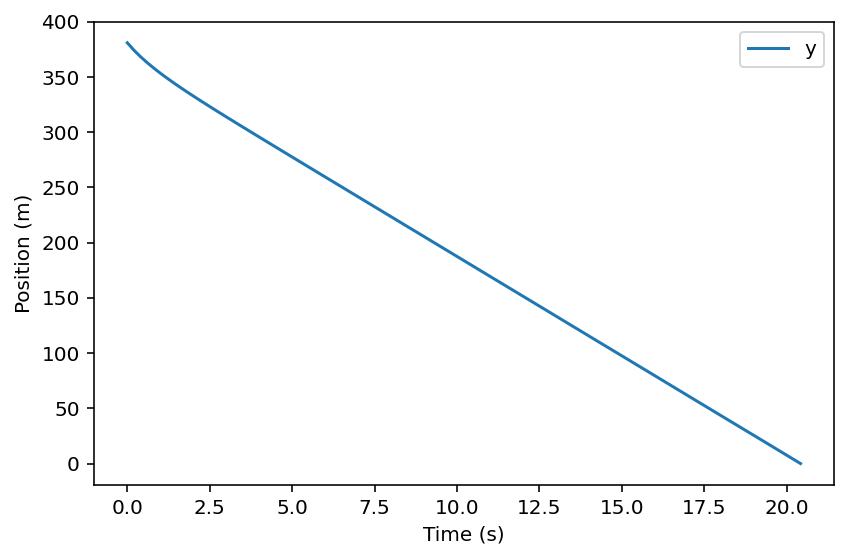

In [32]:
plot_position(results1)

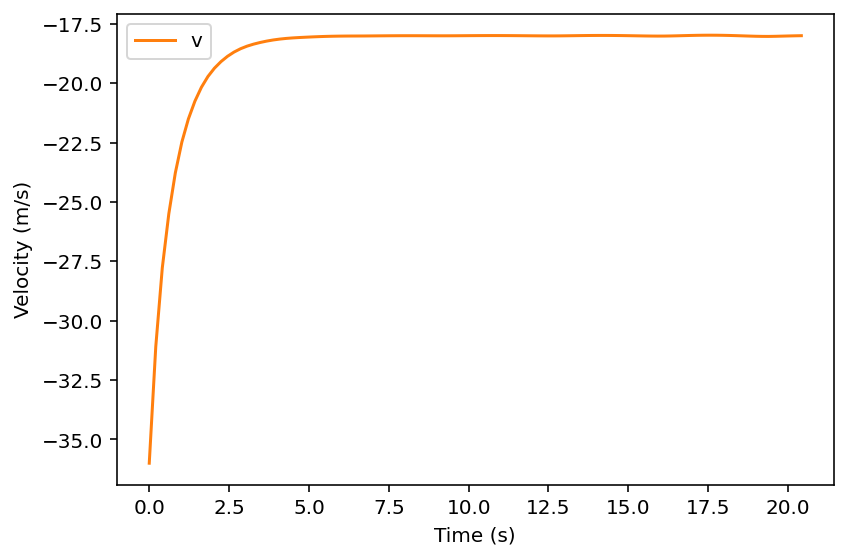

In [33]:
plot_velocity(results1)

### Exercise 2
Suppose we drop a quarter from the Empire State Building and find that its flight time is 19.1 seconds. Use this measurement to estimate terminal velocity and coefficient of drag.

You can get the relevant dimensions of a quarter from https://en.wikipedia.org/wiki/Quarter_(United_States_coin).

Create a `Params` object with new values of `mass` and `diameter`. We don’t know `v_term`, so we’ll start with the initial guess 18 m/s.

Use `make_system` to create a `System` object.

Call `run_solve_ivp` to simulate the system. How does the flight time of the simulation compare to the measurement?

Try a few different values of `v_term` and see if you can get the simulated flight time close to 19.1 seconds.

Optionally, write an error function and use `root_scalar` to improve your estimate.

Use your best estimate of `v_term` to compute `C_d`.

Note: I fabricated the “observed” flight time, so don’t take the results of this exercise too seriously.

In [35]:
params_2 = modsim.Params(
    mass=5.67e-3,
    diameter=24.26e-3,
    rho = 1.2,          # kg/m**3
    g = 9.8,            # m/s**2
    v_init = 0,         # m / s
    v_term = 18,        # m / s
    height = 381,       # m
    t_end = 30,         # s
)

In [36]:
system_2 = make_system(params_2)
system_2

namespace(init=y    381
               v      0
               Name: state, dtype: int64,
          area=0.000462244204111976,
          C_d=0.6183600157463346,
          mass=0.00567,
          rho=1.2,
          g=9.8,
          t_end=30)

In [37]:
results_2, details_2 = modsim.run_solve_ivp(system_2, slope_func, events=event_func)
details_2.message

'A termination event occurred.'

In [38]:
results_2.index[-1]

22.43946505804431

In [42]:
v_term = numpy.linspace(15, 25, 11)
v_term

array([15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.])

In [44]:
for v in v_term:
    params_2 = params_2.set(v_term=v)
    system_2 = make_system(params_2)
    results_2, details_2 = modsim.run_solve_ivp(system_2, slope_func, events=event_func)
    print(f"Time of flight {results_2.index[-1]} s with v_term = {v} m/s")

Time of flight 26.460770600406036 s with v_term = 15.0 m/s
Time of flight 24.942824119585044 s with v_term = 16.0 m/s
Time of flight 23.613772550275876 s with v_term = 17.0 m/s
Time of flight 22.43946505804431 s with v_term = 18.0 m/s
Time of flight 21.395091820400676 s with v_term = 19.0 m/s
Time of flight 20.463387021717956 s with v_term = 20.0 m/s
Time of flight 19.626846949939658 s with v_term = 21.0 m/s
Time of flight 18.872829791552615 s with v_term = 22.0 m/s
Time of flight 18.189621344662587 s with v_term = 23.0 m/s
Time of flight 17.571059994325587 s with v_term = 24.0 m/s
Time of flight 17.006694464787206 s with v_term = 25.0 m/s


In [48]:
v_term = numpy.linspace(21, 22, 20)
for v in v_term:
    params_2 = params_2.set(v_term=v)
    system_2 = make_system(params_2)
    results_2, details_2 = modsim.run_solve_ivp(system_2, slope_func, events=event_func)
    print(f"Time of flight {results_2.index[-1]} s with v_term = {v} m/s")

Time of flight 19.626846949939658 s with v_term = 21.0 m/s
Time of flight 19.585284168971892 s with v_term = 21.05263157894737 m/s
Time of flight 19.543947432848675 s with v_term = 21.105263157894736 m/s
Time of flight 19.50282891478576 s with v_term = 21.157894736842106 m/s
Time of flight 19.4619256204701 s with v_term = 21.210526315789473 m/s
Time of flight 19.42123481247887 s with v_term = 21.263157894736842 m/s
Time of flight 19.38075399290665 s with v_term = 21.31578947368421 m/s
Time of flight 19.340480887745034 s with v_term = 21.36842105263158 m/s
Time of flight 19.300413432741593 s with v_term = 21.42105263157895 m/s
Time of flight 19.26054976051509 s with v_term = 21.473684210526315 m/s
Time of flight 19.22088818874444 s with v_term = 21.526315789473685 m/s
Time of flight 19.181427209281264 s with v_term = 21.57894736842105 m/s
Time of flight 19.142165478063045 s with v_term = 21.63157894736842 m/s
Time of flight 19.103101805724478 s with v_term = 21.684210526315788 m/s
Time 

Looks like `v_term=21.684` m/s makes the time of flight close to 19.1 m/s.

In [60]:
def error_func(v, params):
    params = modsim.Params(params, v_term=v)
    system = make_system(params)
    results, _ = modsim.run_solve_ivp(system, slope_func, events=event_func)
    return results.index[-1] - params.tof

In [61]:
params3 = params_2.set(tof=19.1)
params3

namespace(mass=0.00567,
          diameter=0.02426,
          rho=1.2,
          g=9.8,
          v_init=0,
          v_term=22.0,
          height=381,
          t_end=30,
          tof=19.1)

In [62]:
res = modsim.root_scalar(error_func, params3, bracket=[21, 22])
res

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: 21.68839509108379

In [63]:
params_solution = modsim.Params(params3, v_term=res.root)
system3 = make_system(params_solution)
system3.C_d

0.42592347554049015